##  Evalue la qualité de la prédiction d'un modèle / d'une config en regards des métriques obtenues sur différents pas de temps

In [1]:
# GET PARAMETERS
import os 
import sys
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.train_and_visu_non_recurrent import evaluate_config
from plotting.plotting import error_per_station_calendar_pattern
from examples.train_model_on_k_fold_validation import load_configuration

Training and Hyper-parameter tuning with Ray is not possible


array([ 0,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23], dtype=int32)

In [80]:
import itertools
from bokeh.plotting import figure, show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Whisker
import pandas as pd
import numpy as np 

def plot_scatter_distribution_by_calendar_group(list_of_point_to_plots,x_ticks,station_name):
    data = {'x': [], 'values': []}

    for i, points in enumerate(list_of_point_to_plots):
        data['x'].extend([x_ticks[i]] * len(points))
        data['values'].extend(points)

    # Source des données
    source = ColumnDataSource(pd.DataFrame(data))

    # Scatter plot
    scatter_fig = figure(x_range=x_ticks, title=f"Scatter Plot of Distributions for station {station_name}", height=300, width=1600)
    scatter_fig.circle(x='x', y='values', source=source, size=5, alpha=0.6)
    scatter_fig.xaxis.major_label_orientation = 0.8

    return scatter_fig


def plot_distribution_by_calendar_group(list_of_point_to_plots,x_ticks,station_name):
    boxplot_data = {'x': [], 'q1': [], 'q2': [], 'q3': [], 'lower': [], 'upper': []}

    for i, points in enumerate(list_of_point_to_plots):
        if len(points) == 0:
            # Ajouter un espace vide pour préserver l'espacement
            boxplot_data['x'].append(x_ticks[i])
            boxplot_data['q1'].append(0)
            boxplot_data['q2'].append(0)
            boxplot_data['q3'].append(0)
            boxplot_data['lower'].append(0)
            boxplot_data['upper'].append(0)
            continue

        q1 = np.percentile(points, 25) 
        q2 = np.percentile(points, 50)  # Médiane
        q3 = np.percentile(points, 75) 
        iqr = q3 - q1
        lower_bound = max(q1 - 1.5 * iqr, np.min(points)) 
        upper_bound = min(q3 + 1.5 * iqr, np.max(points)) 

        boxplot_data['x'].append(x_ticks[i])
        boxplot_data['q1'].append(q1)
        boxplot_data['q2'].append(q2)
        boxplot_data['q3'].append(q3)
        boxplot_data['lower'].append(lower_bound)
        boxplot_data['upper'].append(upper_bound)

    source_box = ColumnDataSource(boxplot_data)

    # Créer la figure pour le boxplot
    box_fig = figure(x_range=x_ticks, title=f"Box Plot of Distributions for station {station_name}", height=300, width=1600)
    box_fig.segment(x0='x', y0='upper', x1='x', y1='q3', source=source_box, line_width=2, color="black")
    box_fig.segment(x0='x', y0='lower', x1='x', y1='q1', source=source_box, line_width=2, color="black")

    # Box Plot
    box_fig.vbar(x='x', width=0.7, top='q3', bottom='q1', source=source_box, fill_color="skyblue", line_color="black")

    # Add maedian
    box_fig.segment(x0='x', y0='q2', x1='x', y1='q2', source=source_box, line_width=2, color="black")

    # Box plot 
    box_fig.add_layout(Whisker(source=source_box, base='x', upper='upper', lower='lower'))
    box_fig.xaxis.major_label_orientation = 0.8
    return box_fig

In [82]:
# Preprocesss / Init
t_minus_1 = ds.tensor_limits_keeper.df_verif_train.iloc[:,-2].reset_index(drop=True)
s_hours = t_minus_1.dt.hour
s_weekdays = t_minus_1.dt.weekday
s_minutes = t_minus_1.dt.minute

posible_hours = s_hours.unique()
posible_hours.sort()
posible_weekdays = s_weekdays.unique()
posible_weekdays.sort()
posible_minutes = s_minutes.unique()
posible_minutes.sort()

couples = list(itertools.product(posible_weekdays,posible_hours,posible_minutes))
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

x_ticks = []
for weekday,hour,minutes in couples:
    x_ticks.append(f"{hour}:{minutes}h - {days[weekday]}")


for station_ind in [0]: # np.arange(len(ds.spatial_unit)):
    # Load data to plot
    list_of_point_to_plots = []
    for weekday,hour,minute in couples:
        indexes = t_minus_1[s_hours.isin([hour])&s_weekdays.isin([weekday])&s_minutes.isin([minute])].index
        clustered_volume = ds.U_train[indexes,station_ind,-1].numpy()
        list_of_point_to_plots.append(clustered_volume)

    # plot 
    box_fig = plot_distribution_by_calendar_group(list_of_point_to_plots,x_ticks,ds.spatial_unit[station_ind])
    scatter_fig = plot_scatter_distribution_by_calendar_group(list_of_point_to_plots,x_ticks,ds.spatial_unit[station_ind])
    # Afficher
    #show(column(scatter_fig, box_fig))
    show(box_fig)


## Load Config from HP tuning
```trial_id = 'subway_in_STGCN_MSELoss_2025_01_06_08_00_94523'
# "subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_23_12_41192"
# "subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963"
# 'subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_05_04_80480'
# "subway_in_STGCN_MSELoss_2025_01_06_08_00_94523"
args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

In [58]:
for trial_id in ['subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963',
                 'subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
                 "subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963",
                 #"subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_09_07_54_72902" # contient  Instagram, Google Maps, Deezer, WhatsApps, Twiteter, DL, UL
                 ]:

    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test','valid'] # ['test','valid','train']
    modification ={'keep_best_weights':True,
                   'epochs':100
                   }
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [0])

    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (30,5*len(station)),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station)

Trial id:  subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963

>>>> Load best CONFIG


AttributeError: 'Namespace' object has no attribute 'validation_split_method'

## Sans Week-ends

Trial id:  subway_in_STGCN_MSELoss_2025_01_06_08_00_94523

>>>> Load best CONFIG



Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

92 train samples had been added thank to Data Augmentation
calendar_dayofweek data augmented by dupplication but not modified
calendar_hour data augmented by dupplication but not modified
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2913 940 940

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let

Loading BokehJS ...

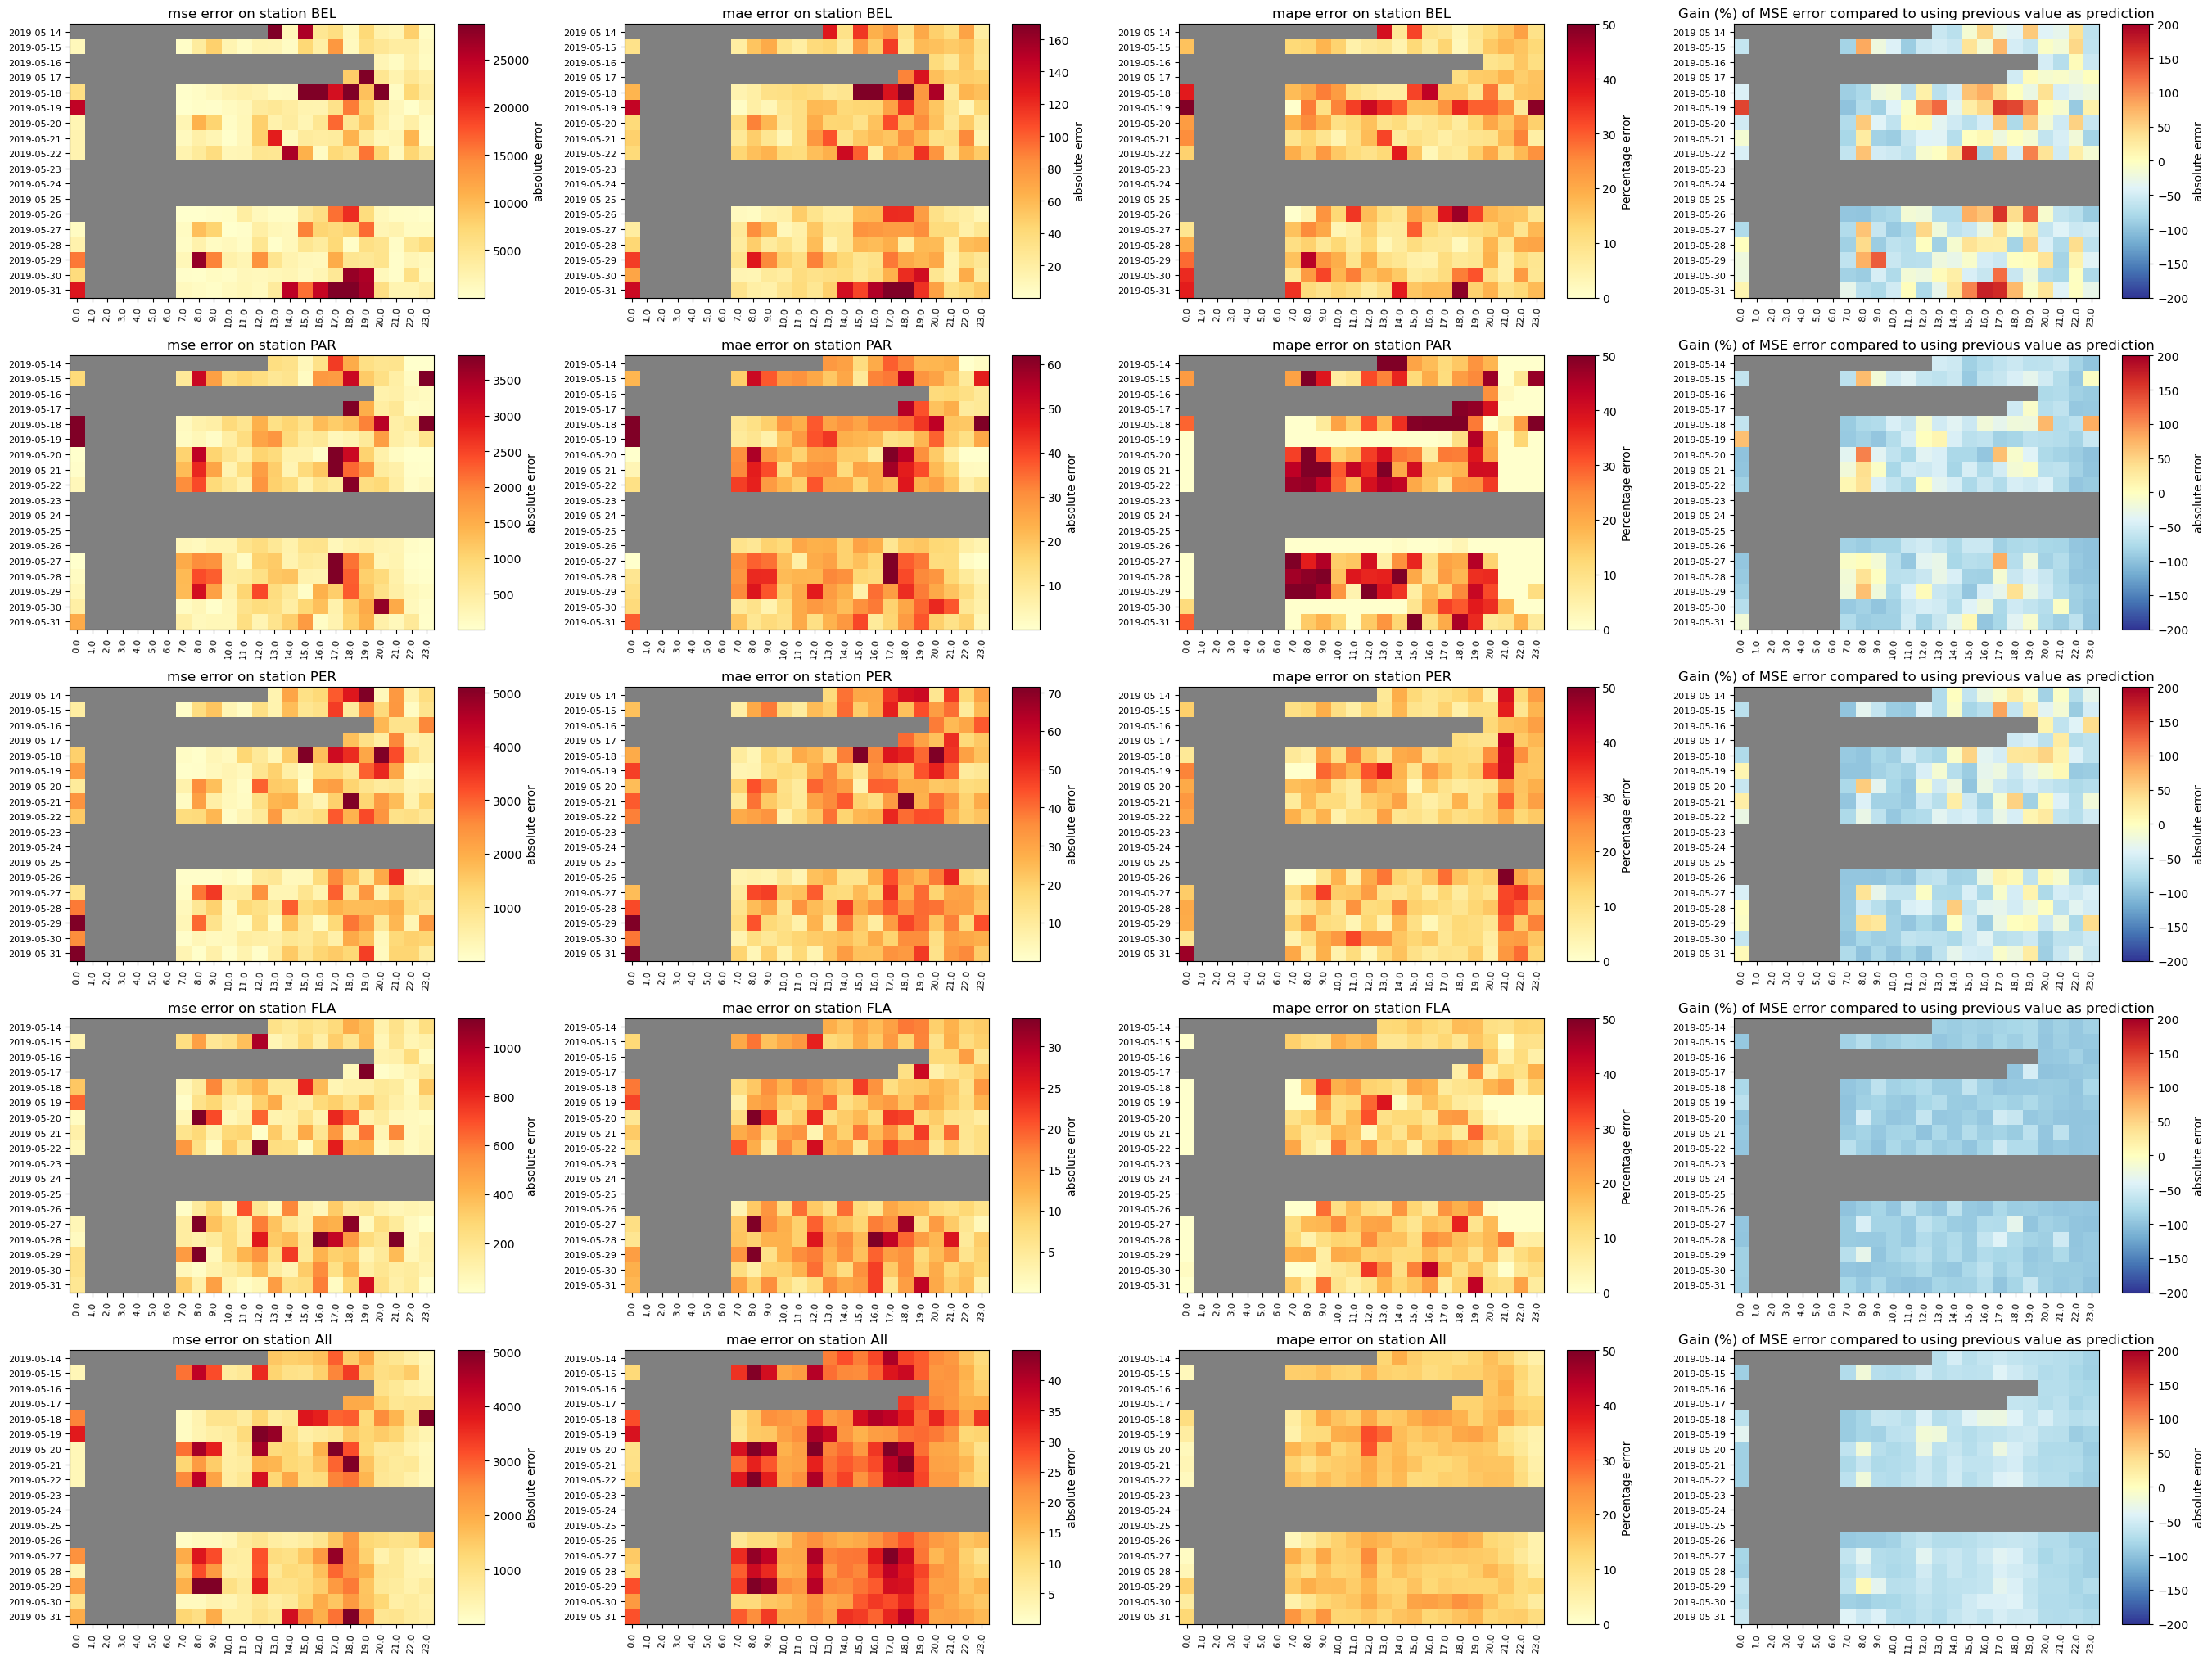

In [2]:
for trial_id in ['subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
                 ]:
    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test']#,'valid','train']
    modification ={'keep_best_weights':True,
                   'epochs':10,
                   'validation_split_method' : 'forward_chaining_cv',
                   'min_fold_size_proportion': 0.75,
                   'train_prop':0.6,
                   'valid_prop':0.2,
                   'test_prop':0.2,
                   'data_augmentation':True,  #False
                   'DA_method':'interpolation',
                   'DA_moment_to_focus' :[{'hours':[0,23],'weekdays':[1,3]}], # None
                   #'W' : args_best_model.Weeks,
                   #'D' : args_best_model.Days,
                   #'historical_length':args_best_model.H
                   }
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [args_best_model.K_fold-1] #[0]
                                                    
                                                    )

    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 40  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        day_date = getattr(ds_no_shuffle.tensor_limits_keeper,f"df_verif_{training_mode}").iloc[:,-1].dt.date.unique()
        nb_days = (day_date.max()-day_date.min()).days
        y_size = 1.2*nb_days #4,15
        x_size = 6.8*len(station)
        fig,axes = error_per_station_calendar_pattern(trainer,ds_no_shuffle,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (x_size,y_size),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station,
                                                    index_matshow = 'date',
                                                    columns_matshow = 'hour')
    break

## Avec Week-ends

Trial id:  subway_in_STGCN_MSELoss_2025_01_06_08_00_94523

>>>> Load best CONFIG

Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

calendar_dayofweek data augmented by dupplication but not modified
calendar_hour data augmented by dupplication but not modified
U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 5642 940 940

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in mu

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

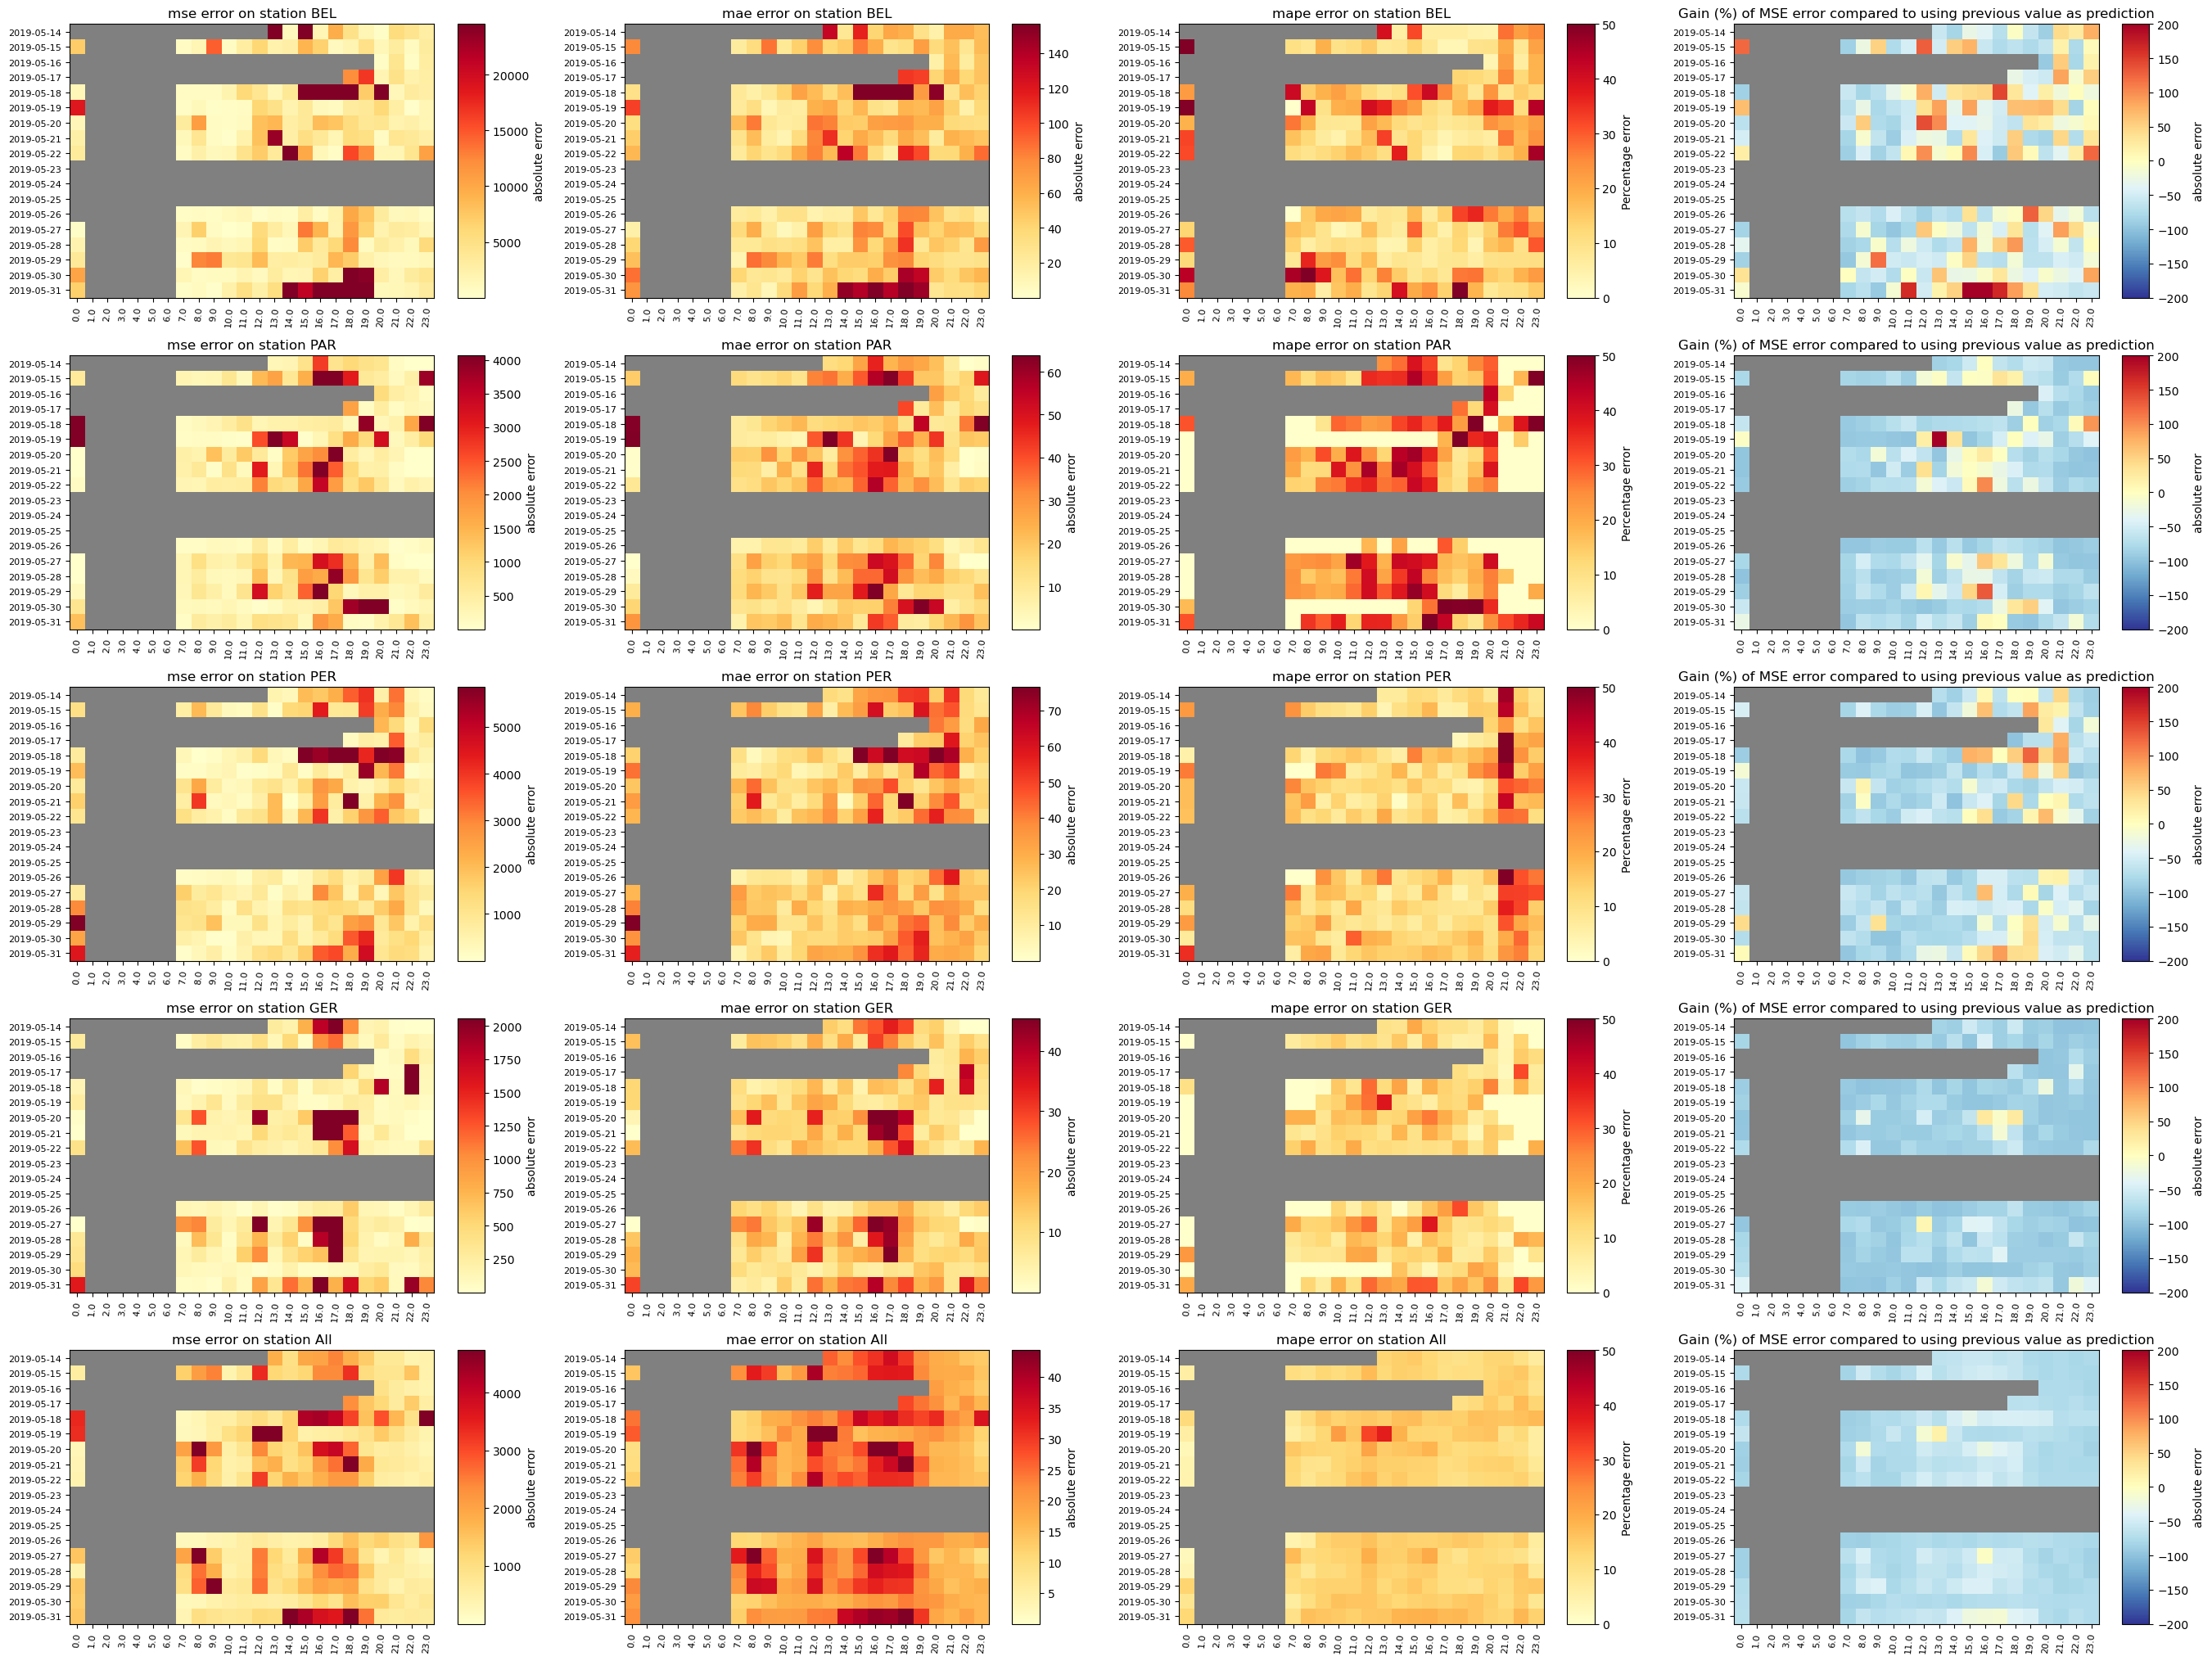

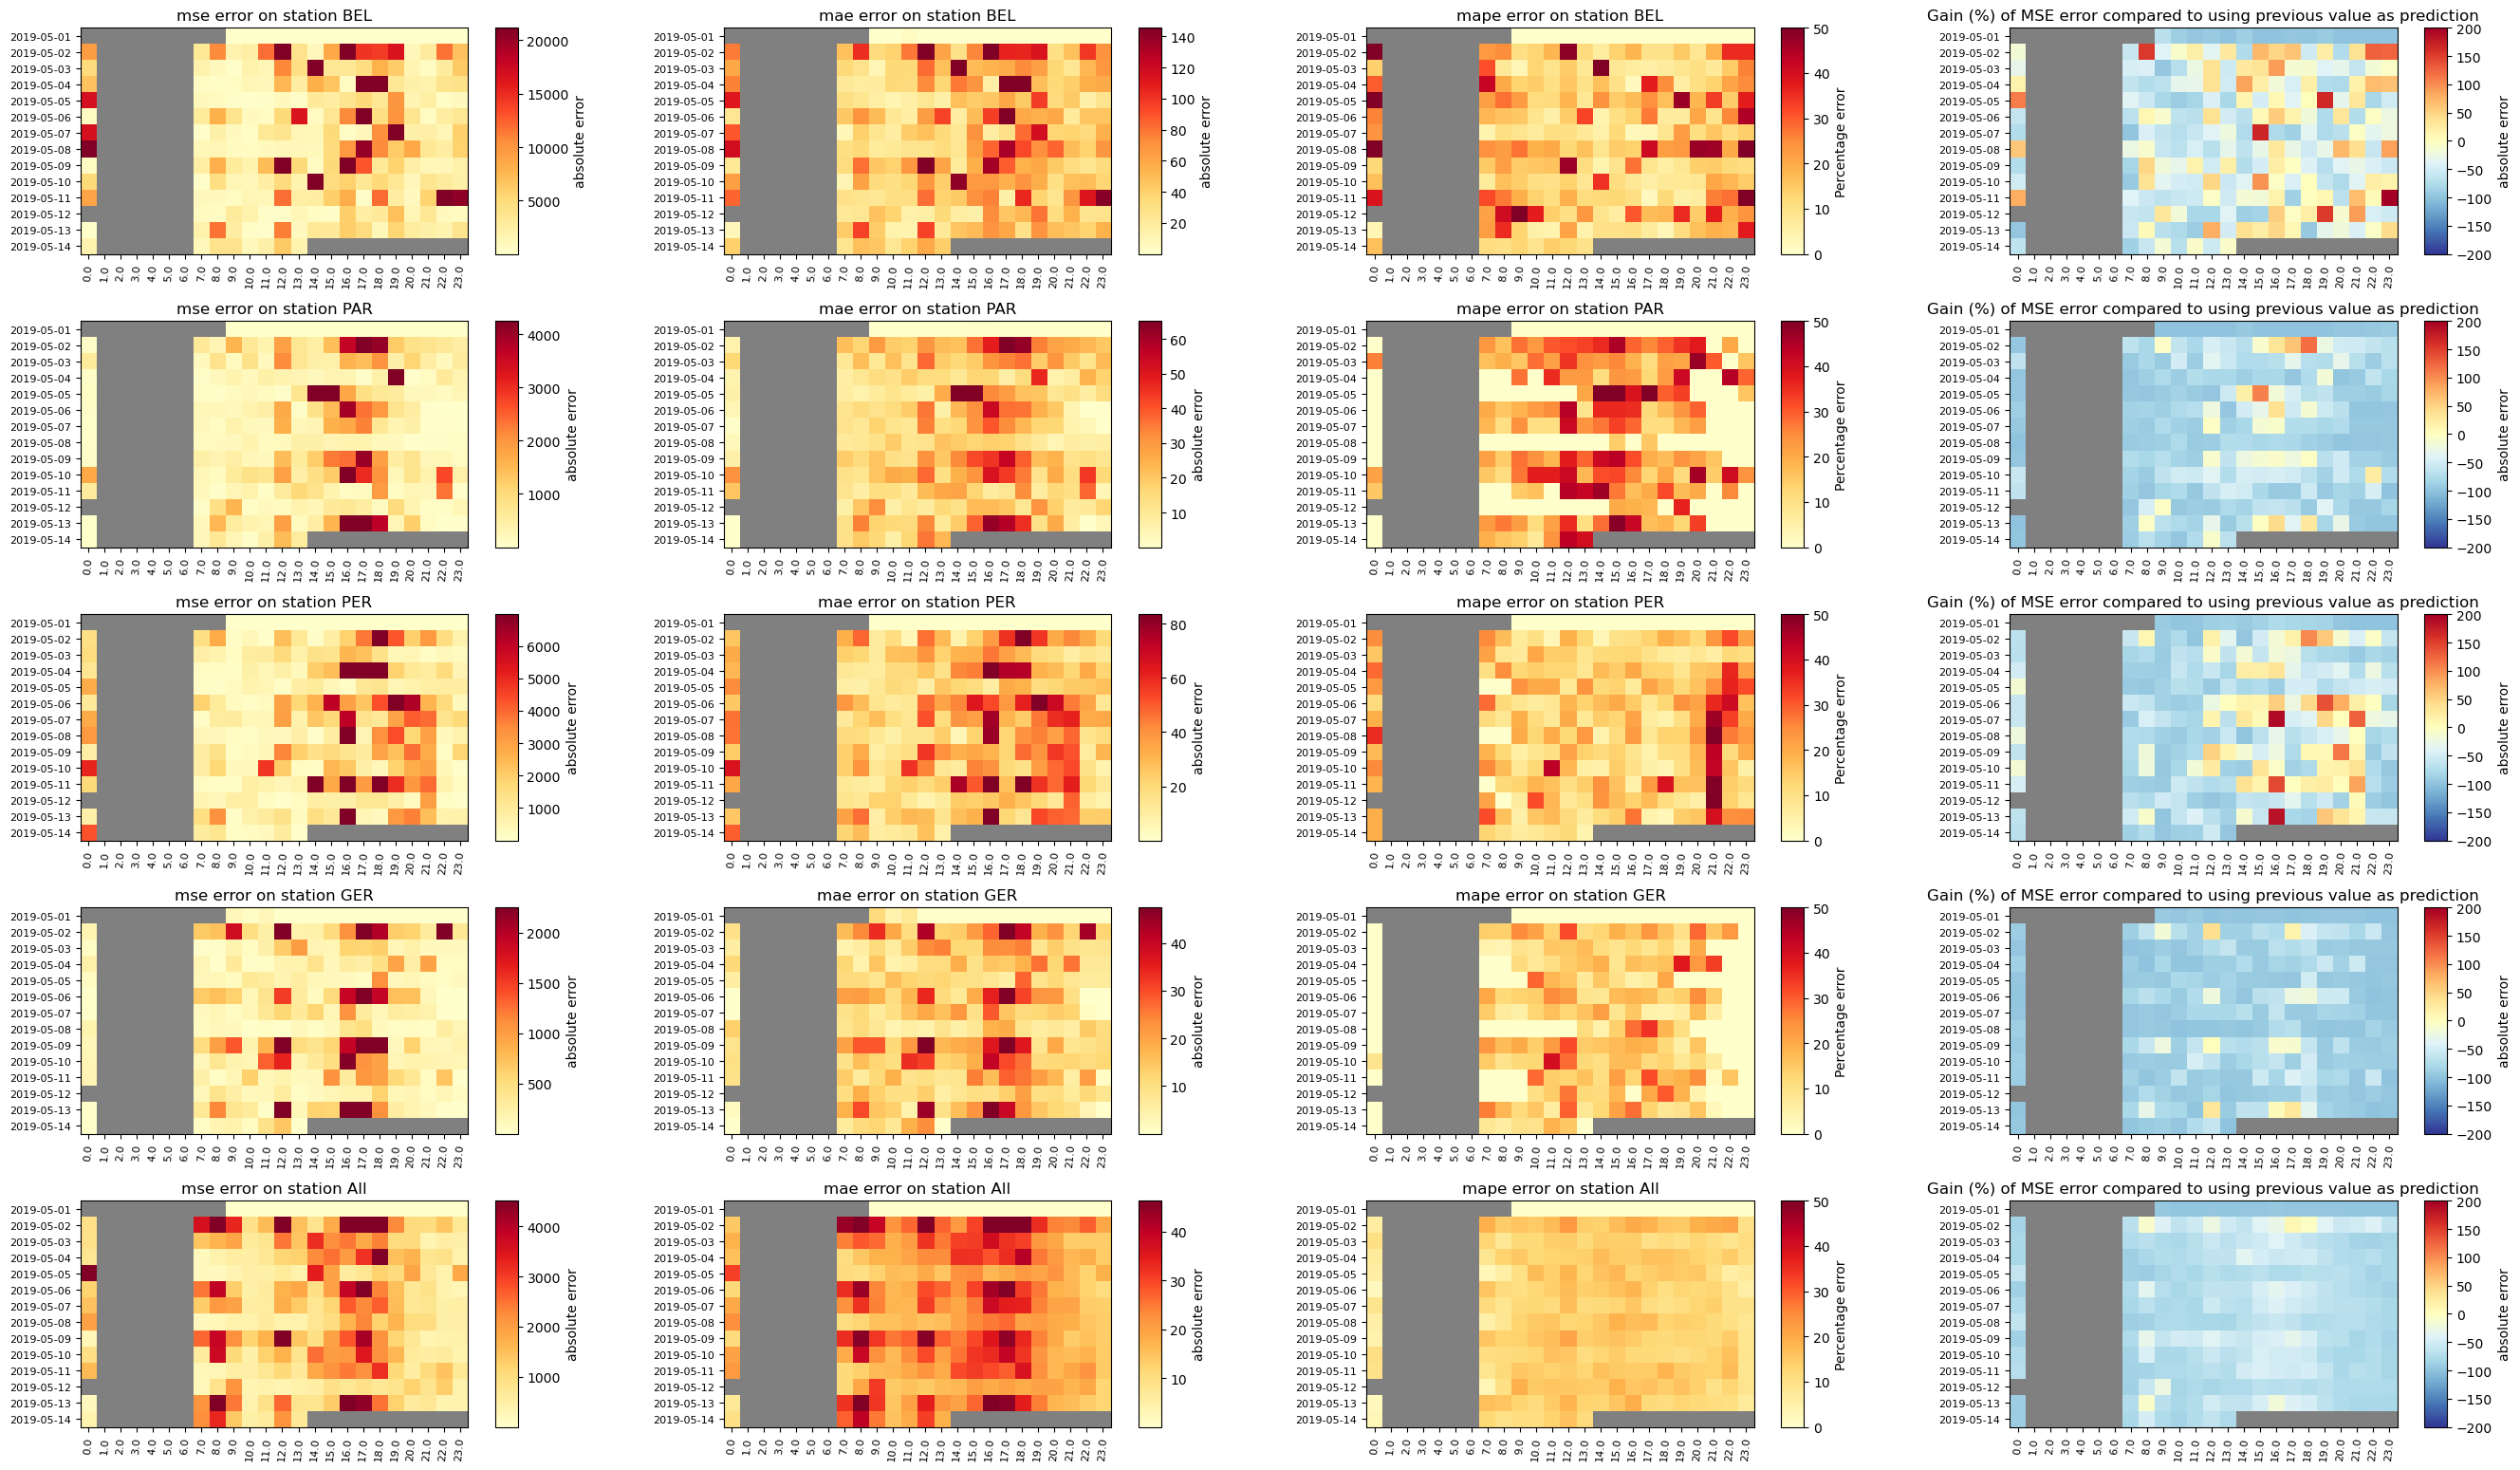

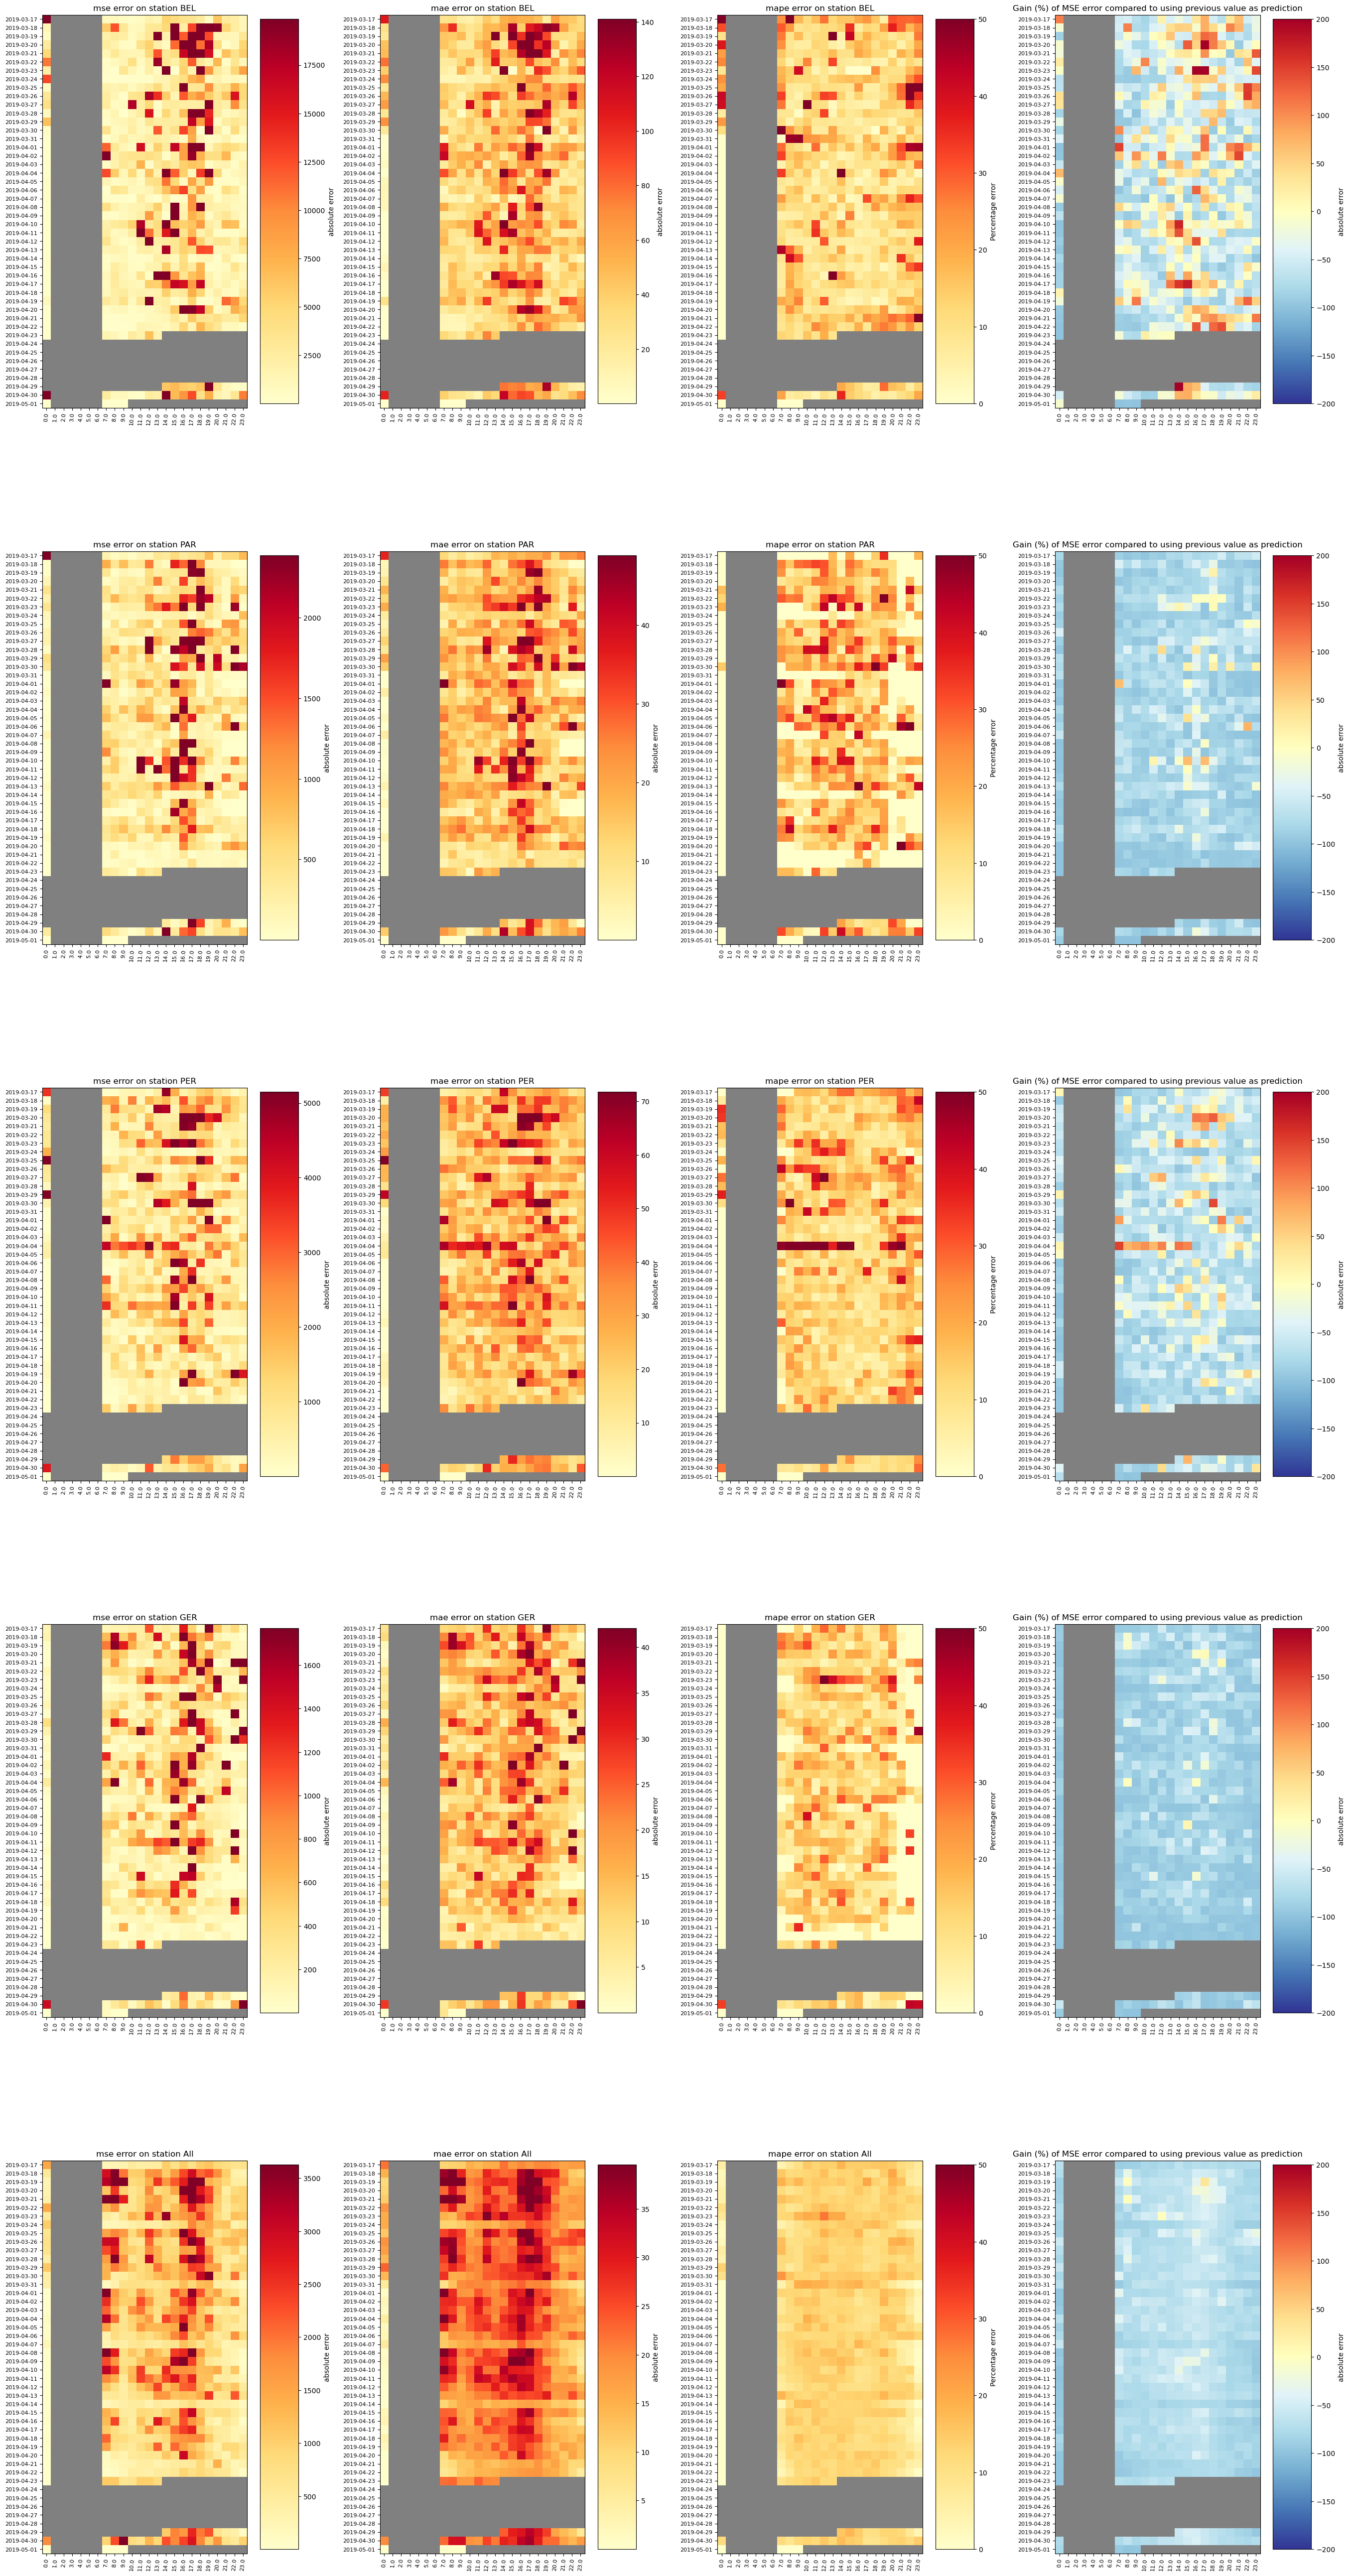

In [2]:
for trial_id in ['subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
                 ]:
    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','GER']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test','valid','train']#,'valid','train']
    modification ={'keep_best_weights':True,
                   'epochs':100,
                   'validation_split_method' : 'forward_chaining_cv',
                   'min_fold_size_proportion': 0.75,
                   'train_prop':0.6,
                   'valid_prop':0.2,
                   'test_prop':0.2,
                   'data_augmentation':True
                   }
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [args_best_model.K_fold-1] #[0]
                                                    
                                                    )

    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 40  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        
        # Set figsize:
        day_date = getattr(ds_no_shuffle.tensor_limits_keeper,f"df_verif_{training_mode}").iloc[:,-1].dt.date.unique()
        nb_days = (day_date.max()-day_date.min()).days
        y_size = 1.2*nb_days #4,15
        x_size = 6.8*len(station)
        fig,axes = error_per_station_calendar_pattern(trainer,ds_no_shuffle,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (x_size,y_size),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station,
                                                    index_matshow = 'date',
                                                    columns_matshow = 'hour')
    break

In [ ]:
for trial_id in ['subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963',
                 ]:

    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test']#,'valid','train']
    modification ={'keep_best_weights':True,
                   'epochs':100,
                   'validation_split_method' : 'forward_chaining_cv',
                   'min_fold_size_proportion': 0.75,
                   'train_prop':0.6,
                   'valid_prop':0.2,
                   'test_prop':0.2,
                   'data_augmentation':True
                   }
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [args_best_model.K_fold-1] #[0]
                                                    
                                                    )

    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 40  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (30,5*len(station)),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station,
                                                    index_matshow = 'date',
                                                    columns_matshow = 'hour')
    break

In [ ]:
for trial_id in ['subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_23_12_41192',
                 'subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
                 "subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963",
                 #"subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_09_07_54_72902" # contient  Instagram, Google Maps, Deezer, WhatsApps, Twiteter, DL, UL
                 ]:

    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test','valid'] # ['test','valid','train']
    modification ={'keep_best_weights':True,
                   'epochs':100
                   }
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [0])

    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (30,5*len(station)),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station)
    break


In [ ]:
ds.tensor_limits_keeper.df_verif_train.iloc[t+]

In [ ]:
for training_mode in ['train']:
    min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
    limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
    fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                freq='1h',
                                                min_flow=min_flow,
                                                figsize = (30,5*len(station)),
                                                limit_percentage_error = limit_percentage_error,
                                                stations = station)

In [56]:
from plotting.plotting import get_y_size_from_temporal_agg,temporal_aggregation_of_attn_weight
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 

def plot_attn_weight(trainer,nb_calendar_data,ds,training_mode = None,temporal_agg = None,save=None,stations= None):

    # Load Inputs : 
    X,Y,X_c,nb_contextual = trainer.load_all_inputs_from_training_mode(training_mode)
    

    X = X.to(trainer.args.device)
    Y = Y.to(trainer.args.device)
    X_c = [x_c.to(trainer.args.device)for x_c in X_c]
    # Init:
    num_heads = trainer.args.args_vision.num_heads
    spatial_units = list(ds.spatial_unit)
    if stations is not None :
        nb_stations_to_plot = len(stations)*num_heads 
    else :
        stations = list(ds.spatial_unit)
        nb_stations_to_plot = Y.size(1)*num_heads 
    num_cols = 4
    

    nb_rows = (nb_stations_to_plot + num_cols - 1) // num_cols  
    y_size = get_y_size_from_temporal_agg(temporal_agg)
    #plt.figure(figsize=(5*num_cols,y_size))  
    plt.figure(figsize=(5*num_cols*max(1,nb_stations_to_plot//15),int(y_size*max(1,nb_stations_to_plot//num_cols))))


    for station_i in range(nb_stations_to_plot//num_heads):

        station_ind  = spatial_units.index(stations[station_i])

        enhanced_x,attn_weights = trainer.model.netmob_vision.model[station_ind](X[:,station_ind,:],X_c[station_ind+nb_calendar_data],x_known = None)
        nb_contextuals = attn_weights.size(-1)

        mh_attn_weights_reshaped = attn_weights.squeeze().detach().cpu().numpy()  # Shape [B,num_heads,P]
        for head_i in range(num_heads):
            if num_heads == 1:
                attn_weights_reshaped = mh_attn_weights_reshaped
            else:
                attn_weights_reshaped = mh_attn_weights_reshaped[:,head_i,:]
            

            # Temporal Aggregation of attn weight:
            attn_weights_reshaped,str_dates = temporal_aggregation_of_attn_weight(attn_weights_reshaped,ds,training_mode,temporal_agg)
            ax = plt.subplot(nb_rows, num_cols, (station_i*num_heads)+head_i + 1)  # Créer un subplot

            vmin,vmax = 0,min(1,1/(nb_contextuals/3)) 
            im = ax.imshow(attn_weights_reshaped, cmap='hot', aspect='auto',vmin=vmin,vmax=vmax)
            plt.colorbar(im,label='Attention Weight',shrink = 0.25)
            
            if temporal_agg is None:
                plt.title(f'Attention Weight\nof station {station_ind} ({spatial_units[station_ind]}) head {head_i} \nfor each sample of the batch')
                plt.ylabel('Samples')
            else:
                plt.title(f'Mean Attention Weight\nof station {station_i}({spatial_units[station_ind]}) head {head_i} \nby calendar class') 
                plt.ylabel('Calendar class')
            plt.xlabel('Contextual time-series')


            num_samples, nb_contextual_on_plot_i = attn_weights_reshaped.shape
            plt.xticks(ticks=np.arange(nb_contextual_on_plot_i), labels=[f'Unit {i}' for i in range(nb_contextual_on_plot_i)], rotation=45)
            plt.yticks(ticks=np.arange(num_samples), labels=str_dates)

        plt.tight_layout()

    if save is not None:
        plt.savefig(f'{save}.pdf',format = 'pdf',bbox_inches='tight')
    plt.show()

def temporal_aggregation_of_attn_weight(attn_weights_reshaped,ds,training_mode,temporal_agg):
    ''' 
    Return the temporal aggregation of attn weights to visualise them 

    args:
    ------
    temporal_agg : choices ['hour','weekday','weekday_hour','weekday_hour_minutes']
    '''

    if temporal_agg is not None:
        index_df = getattr(ds.tensor_limits_keeper,f"df_verif_{training_mode}").iloc[:,-1]
        df = pd.DataFrame(attn_weights_reshaped,index = index_df) #,columns = ds.spatial_unit)
        weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']


        if temporal_agg == 'hour':
            df_agg = df.groupby([df.index.hour]).agg('mean')
            str_dates = list(df_agg.index.map(lambda x: f"{x:02d}"))

        elif temporal_agg == 'weekday':
            df_agg = df.groupby([df.index.weekday]).agg('mean')
            str_dates = list(df_agg.index.map(lambda x: weekdays[x]))

        elif temporal_agg == 'weekday_hour':
            df_agg = df.groupby([df.index.weekday,df.index.hour]).agg('mean')
            str_dates = list(df_agg.index.map(lambda x: f"{weekdays[x[0]]} {x[1]:02d}"))

        elif temporal_agg == 'weekday_hour_minute':
            df_agg = df.groupby([df.index.weekday,df.index.hour,df.index.minute]).agg('mean')
            str_dates = list(df_agg.index.map(lambda x: f"{weekdays[x[0]]} {x[1]:02d}:{x[2]:02d}"))
        else:
            raise NotImplementedError(f'Temporal aggregation {temporal_agg} has not been implemented')
        attn_weights_reshaped = df_agg.values  
    else:
        str_dates = list(df.index.strftime('%Y-%m-%d %H:%M'))

    return attn_weights_reshaped,str_dates


In [ ]:
from constants.paths import CALENDAR_TYPE
nb_calendar_data = len(CALENDAR_TYPE)

training_mode = 'test'
temporal_agg = 'weekday_hour' # 'hour' # 'weekday' # 'weekday_hour'
save = 'attn_weight'

plot_attn_weight(trainer,nb_calendar_data,ds= ds,training_mode = training_mode,temporal_agg = temporal_agg,save=save,stations= ['CUS','PER','PAR'])

In [ ]:
trainer.model.netmob_vision.model[0].attention.W_v

In [ ]:
from plotting.plotting import plot_attn_weight
from constants.paths import CALENDAR_TYPE
nb_calendar_data = len(CALENDAR_TYPE)

training_mode = 'test'
temporal_agg = 'weekday_hour' # 'hour' # 'weekday' # 'weekday_hour'
save = 'attn_weight'
plot_attn_weight(trainer,nb_calendar_data,ds,training_mode,temporal_agg,save)

### Evaluate config :

In [ ]:
for trial_id in ['subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
                 "subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963",
                 "subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_23_12_41192"]:

    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test','valid'] # ['test','valid','train']
    modification ={'keep_best_weights':True}
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [0])


    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (30,5*len(station)),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station)

## Load config defined 'by hand' :

In [ ]:
dataset_names = ["subway_in"] # ["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
dataset_for_coverage = ['subway_in','netmob_image_per_station'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
model_name = 'STGCN'

station = ['BEL','PAR','AMP','FLA']   # 'BON'  #'GER'
# ...

modification = {'epochs' : 1, #100
                'lr':4e-4}
training_mode_to_visualise = ['test']

(trainer,ds,ds_no_shuffle,args) = evaluate_config(model_name,dataset_names,dataset_for_coverage,
                                                   station = station,modification=modification,training_mode_to_visualise=training_mode_to_visualise)